In [1]:
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

pd.options.display.float_format = '{:.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
sns.set()
warnings.filterwarnings("ignore")

In [2]:
def calculate_age(born, year):
    """year年4月1日時点の年齢を返す"""
    date = datetime(year,4,1)
    return date.year - born.year - ((date.month, date.day) < (born.month, born.day))

def is_same_team(df, col):
    return (df['team'] in df[col])*1

In [3]:
# データ読み込み
train_2018_df = pd.read_csv('./data/train_2018.csv')
train_2017_df = pd.read_csv('./data/train_2017.csv')
train_2016_df = pd.read_csv('./data/train_2016.csv')
train_2018_df['year'] = 2018
train_2017_df['year'] = 2017
train_2016_df['year'] = 2016

test_df = pd.read_csv('./data/test.csv')
test_df['year'] = 2019

t_df_dic = {2018: test_df, 2017: train_2018_df, 2016: train_2017_df, 2015: train_2016_df}

In [18]:
train_2018_df

,id,team,No,name,time_played,position,height,weight,salary,nth_year,is_youth,nationality,j1_total_num_played,j1_total_scores,j2_total_num_played,j2_total_scores,j3_total_num_played,j3_total_scores,na_total_num_played,na_total_scores,prev3_team,prev2_team,prev1_team,prev3_div,prev2_div,prev1_div,prev3_num_played,prev2_num_played,prev1_num_played,prev3_scores,prev2_scores,prev1_scores,prev3_time_played,prev2_time_played,prev1_time_played,year,rat_full_play,rat_out_play,rat_in_play,rat_inout_play,rat_bench_play,rat_susp_play,rat_full_play_first,rat_out_play_first,rat_in_play_first,rat_inout_play_first,rat_bench_play_first,rat_susp_play_first,rat_full_play_second,rat_out_play_second,rat_in_play_second,rat_inout_play_second,rat_bench_play_second,rat_susp_play_second,age
0,2,C大阪,2.0000,松田 陸,2524.0000,DF,171.0000,69.0000,2000,3.0000,nan,NaN,47.0000,3.0000,42.0000,2.0000,nan,nan,nan,nan,FC東京,C大阪,C大阪,1,2,1,9,42,31,0,2,2,473,3733,2662,2018,0.5588,0.0000,0.3529,0.0000,0.0882,0.0000,0.2647,0.0000,0.2059,0.0000,0.0294,0.0000,0.2941,0.0000,0.1471,0.0000,0.0588,0.0000,26
1,5,C大阪,5.0000,田中 裕介,279.0000,DF,181.0000,77.0000,2700,4.0000,nan,NaN,223.0000,10.0000,42.0000,1.0000,nan,nan,nan,nan,C大阪,C大阪,C大阪,2,2,1,9,33,18,1,0,0,664,2725,492,2018,0.1176,0.4118,0.0000,0.0000,0.4706,0.0000,0.0294,0.2059,0.0000,0.0000,0.2647,0.0000,0.0882,0.2059,0.0000,0.0000,0.2059,0.0000,31
2,6,C大阪,6.0000,山口 蛍,2970.0000,MF,173.0000,72.0000,6700,10.0000,1.0000,NaN,134.0000,12.0000,58.0000,2.0000,nan,nan,38.0000,2.0000,C大阪・GER,C大阪,C大阪,2,2,1,35,19,32,1,1,2,3150,1800,2880,2018,0.9412,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4412,0.0000,0.0000,0.0000,0.0000,0.0000,27
3,7,C大阪,7.0000,水沼 宏太,1671.0000,MF,176.0000,72.0000,3000,2.0000,nan,NaN,194.0000,24.0000,50.0000,7.0000,9.0000,3.0000,nan,nan,鳥栖,FC東京,C大阪,1,1,1,32,17,24,7,1,3,2353,570,1901,2018,0.2647,0.0882,0.3529,0.0000,0.0882,0.0000,0.0294,0.0882,0.0882,0.0000,0.0882,0.0000,0.2353,0.0000,0.2647,0.0000,0.0000,0.0000,28
4,8,C大阪,8.0000,柿谷 曜一朗,1424.0000,FW,177.0000,68.0000,7200,10.0000,1.0000,NaN,113.0000,39.0000,168.0000,23.0000,nan,nan,18.0000,5.0000,SUI,C大阪,C大阪,9,2,1,4,20,34,1,5,6,-,1635,2918,2018,0.5588,0.0000,0.4412,0.0000,0.0000,0.0000,0.3529,0.0000,0.1471,0.0000,0.0000,0.0000,0.2059,0.0000,0.2941,0.0000,0.0000,0.0000,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,739,名古屋,29.0000,和泉 竜司,2139.0000,MF,173.0000,72.0000,1400,3.0000,nan,NaN,14.0000,1.0000,39.0000,1.0000,nan,nan,nan,nan,名古屋,名古屋,名古屋,1,1,2,0,14,39,0,1,1,0,816,3270,2018,0.7857,0.0714,0.0714,0.0000,0.0000,0.0000,0.4048,0.0238,0.0238,0.0000,0.0000,0.0000,0.3810,0.0476,0.0476,0.0000,0.0000,0.0000,24
460,740,名古屋,30.0000,松本 孝平,0.0000,FW,186.0000,85.0000,480,2.0000,nan,NaN,nan,nan,0.0000,0.0000,nan,nan,nan,nan,-,-,名古屋,-,-,2,-,-,0,-,-,0,-,-,0,2018,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,23
461,742,名古屋,32.0000,深堀 隼平,106.0000,FW,178.0000,72.0000,400,2.0000,1.0000,NaN,0.0000,0.0000,2.0000,0.0000,nan,nan,nan,nan,-,名古屋,名古屋,-,1,2,-,0,2,-,0,0,-,0,60,2018,0.0000,0.0238,0.0238,0.0000,0.0714,0.0000,0.0000,0.0238,0.0000,0.0000,0.0238,0.0000,0.0000,0.0000,0.0238,0.0000,0.0476,0.0000,19
462,743,名古屋,33.0000,梶山 幹太,0.0000,MF,167.0000,63.0000,380,2.0000,1.0000,NaN,0.0000,0.0000,0.0000,0.0000,nan,nan,nan,nan,-,名古屋,名古屋,-,1,1,-,0,0,-,0,0,-,0,0,2018,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,19


In [4]:
for year in [2018, 2017, 2016, 2015]:
    t_df = t_df_dic[year]
    t_df['name-team'] = t_df['name'] + '-' + t_df['prev1_team'].apply(lambda x: x.split('・')[-1])
    
    # 今回は出場記録から作成した特徴量のみ結合
    eve_pla_df = pd.read_csv(f'./data/output/event_play_{year}.csv')
    
    for df in [eve_pla_df]:
        df['name-team'] = df['name'] + '-' + df['team']
        df.drop(['name', 'team'], axis=1, inplace=True)
        t_df = pd.merge(t_df, df, on='name-team', how='left')
    
    t_df.drop(['name-team'], axis=1, inplace=True)
    t_df_dic[year] = t_df
    
test_df = t_df_dic[2018]
train_2018_df = t_df_dic[2017]
train_2017_df = t_df_dic[2016]
train_2016_df = t_df_dic[2015]

In [5]:
# 欠損値補完・特徴量生成
for df, year in [[test_df, 2019], [train_2018_df, 2018], [train_2017_df, 2017], [train_2016_df, 2016]]:
    df['birthdate'] = pd.to_datetime(df['birthdate'])
    df['age'] = df['birthdate'].apply(lambda x: calculate_age(x, year=year))
    df.drop('birthdate', axis=1, inplace=True)

train_df = pd.concat([train_2018_df, train_2017_df, train_2016_df], axis=0).reset_index(drop=True)

In [6]:
for df in [train_df, test_df]:
    
    # 通算出場試合数が0はベンチ入りはあるということなので、nullとは意味が異なる。これを特徴量とする
    df['is_j1_play'] = ~df['j1_total_num_played'].isnull()*1
    df['is_j2_play'] = ~df['j2_total_num_played'].isnull()*1
    df['is_j3_play'] = ~df['j3_total_num_played'].isnull()*1
    df['is_na_play'] = ~df['na_total_num_played'].isnull()*1
    
    df['is_prev3_same_team'] = df.apply(is_same_team, col='prev3_team', axis=1)
    df['is_prev2_same_team'] = df.apply(is_same_team, col='prev2_team', axis=1)
    df['is_prev1_same_team'] = df.apply(is_same_team, col='prev1_team', axis=1)
    
    for colname in ['is_youth', 'j1_total_num_played', 'j1_total_scores', 'j2_total_num_played', 'j2_total_scores', 
                    'j3_total_num_played', 'j3_total_scores', 'na_total_num_played', 'na_total_scores']:
        df[colname] = df[colname].fillna(0)
    
    for colname in ['nationality']:
        df[colname] = df[colname].fillna('japan')
        
    for colname in ['prev3_div', 'prev2_div', 'prev1_div', 
                    'prev3_num_played', 'prev2_num_played', 'prev1_num_played', 
                    'prev3_scores', 'prev2_scores', 'prev1_scores', 
                    'prev3_time_played', 'prev2_time_played', 'prev1_time_played']:
        df[colname] = df[colname].replace('-',0)
        df[colname] = df[colname].fillna(0)
        df[colname] = df[colname].map(int)
        
    for colname in ['rat_full_play', 'rat_out_play',
       'rat_in_play', 'rat_inout_play', 'rat_bench_play', 'rat_susp_play',
       'rat_full_play_first', 'rat_out_play_first', 'rat_in_play_first',
       'rat_inout_play_first', 'rat_bench_play_first', 'rat_susp_play_first',
       'rat_full_play_second', 'rat_out_play_second', 'rat_in_play_second',
       'rat_inout_play_second', 'rat_bench_play_second',
       'rat_susp_play_second']:
        # 前年の所属リーグがJ1ないしJ2のチームで、値がnullの選手は、0で補完
        ext_rows = (df['prev1_div'].isin(['1', '2'])) & (df[colname].isnull())
        df.loc[ext_rows, colname] = df.loc[ext_rows, colname].fillna(0)
        # 前年の所属リーグがJ1ないしJ2のチームでなく、値がnullの選手は、-999で補完
        ext_rows = (~df['prev1_div'].isin(['1', '2'])) & (df[colname].isnull())
        df.loc[ext_rows, colname] = df.loc[ext_rows, colname].fillna(-999)
        df[colname] = df[colname].map(float)

In [7]:
ID = 'id'
TARGET = 'time_played'

train_x = train_df.drop([TARGET], axis=1)
train_y = train_df[TARGET]
test_x = test_df.copy()

all_x = pd.concat([train_x, test_x])

In [8]:
# 年俸が不明な場合中央値で補完
med_salary = all_x[all_x['salary'] != '-']['salary'].median(skipna=True)
all_x['salary'] = all_x['salary'].mask(all_x['salary'] == '-', med_salary)
all_x['salary'] = all_x['salary'].map(int)

In [9]:
# カテゴリ変数はラベルエンコーディング
cat_columns = ['position', 'nationality']
for c in cat_columns:
    le = LabelEncoder()
    all_x[c].fillna('', inplace=True)
    le.fit(all_x[c])
    all_x[c] = le.transform(all_x[c])

In [10]:
# チーム名は、複数カラムで同じ値でラベルされるように、辞書作成して変換。ただしここでは出現回数が1回のチーム名は同じ値でラベル
team_dic = {}

tmp_dic = pd.concat([all_x['team'], all_x['prev1_team'], all_x['prev2_team'], all_x['prev3_team']]).value_counts().to_dict()
tmp_list = sorted(tmp_dic.items(), key=lambda x:x[-1])

label = 0
for k,v in tmp_list:
    if v == 1:
        team_dic[k] = label
    else:
        team_dic[k] = label
        label += 1

colnames = ['team', 'prev1_team', 'prev2_team', 'prev3_team']
for colname in colnames:
    all_x[colname] = all_x[colname].map(team_dic)

train_x = all_x.iloc[:train_x.shape[0], :].reset_index(drop=True)
test_x = all_x.iloc[train_x.shape[0]:, :].reset_index(drop=True)

In [11]:
# 学習
remove_cols = [ID, TARGET, 'name', 'year']
feature_cols = [col for col in list(train_x) if col not in remove_cols]
cat_cols = ['team', 'prev1_team', 'prev2_team', 'prev3_team', 'position', 'nationality']
SEED = 0

In [12]:
# train, validationのsplitはyearで層化抽出する
tr_x, va_x, tr_y, va_y = train_test_split(train_x, train_y, test_size=0.2, random_state=SEED, stratify=train_x['year'])

tr_x = tr_x[feature_cols]
va_x = va_x[feature_cols]
tt_x = test_x[feature_cols]

tr_x.reset_index(drop=True, inplace=True)
va_x.reset_index(drop=True, inplace=True)
tr_y.reset_index(drop=True, inplace=True)
va_y.reset_index(drop=True, inplace=True)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 14,
    'max_depth': 6,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.7,
    'min_data_in_leaf': 10,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.4,
    "lambda_l2": 0.4,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

tr_data = lgb.Dataset(tr_x, label=tr_y)
va_data = lgb.Dataset(va_x, label=va_y)

In [13]:
model = lgb.train(
    params, 
    tr_data, 
    categorical_feature = cat_cols,
    valid_names = ['train', 'valid'],
    valid_sets =[tr_data, va_data], 
    verbose_eval = 100,
)

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 392.067	valid's rmse: 815.833
Early stopping, best iteration is:
[34]	train's rmse: 594.296	valid's rmse: 784.086


In [14]:
va_pred = model.predict(va_x, num_iteration=model.best_iteration)
score = np.sqrt(mean_squared_error(va_y, va_pred))

pred_df = pd.DataFrame(sorted(zip(va_x.index, va_pred, va_y)), columns=['index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), tr_x.columns)), columns=['importance', 'feature'])

print(f'rmse: {score:.4f}')

rmse: 784.0856


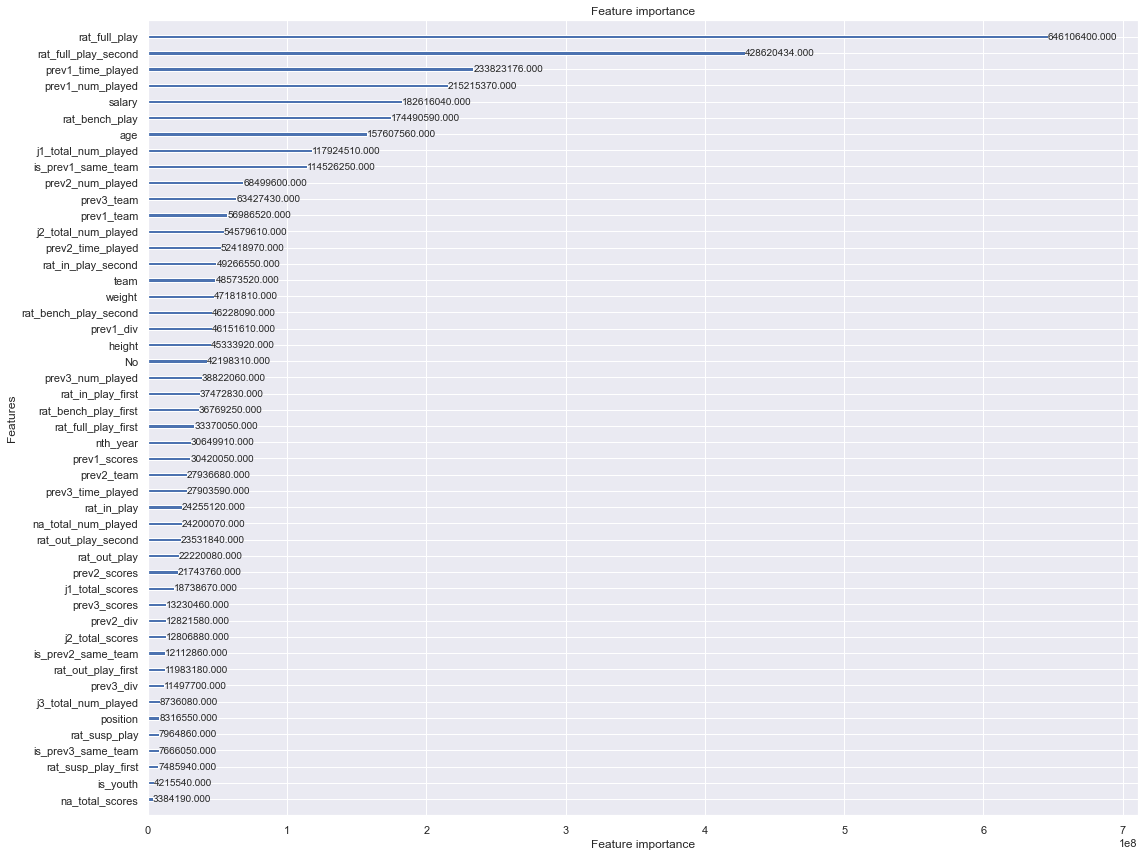

In [15]:
lgb.plot_importance(model, figsize=(16,12), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()

In [17]:
tt_pred = model.predict(tt_x, num_iteration=model.best_iteration)
test_df[TARGET] = tt_pred

sub_df = pd.read_csv('./data/sample_submission.csv')

sub_df = pd.merge(sub_df[[ID]], test_df[[ID, TARGET]], on=ID)
sub_df.to_csv('./data/output/tutorial_submission.csv', index=False)